In [1]:
import os, glob, torch, torchvision, cv2, PIL, time, random
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from copy import deepcopy

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# 5x: raw/flip/rotate/jitter/blur
# ResNet & VGG
CFG={'SEED' : 42,
     'IMG_SIZE' : 224,
     'AUGMENTATION' : 2,  # 1: ONLY flip / 2: 5가지 다
     'TEST_PORTION' : 0.5,  # Test set 비율
     'CROSS_VALIDATION' : 0,  # 0~4: 몇 번째 subset을 Validation으로 할 것인지
     'MODEL' : 3,  # 1: ResNet / 2: VGG / 3: Inception_v3
     'CONTROL' : "NON_SJS",  # "NORMAL" or "NON_SJS"
     'gland' : "SMG_",  # "PTG_" or "SMG_"
     'EPOCHS' : 30,
     'BATCH_SIZE' : 64,
     'LR' : 1e-4}

In [5]:
control = CFG["CONTROL"]

if CFG["AUGMENTATION"] == 1:
    augmentation = "2x"
else:
    augmentation = "5x"

if CFG["TEST_PORTION"] == 0.1:
    test_portion = "test10"
elif CFG["TEST_PORTION"] == 0.2:
    test_portion = "test20"
elif CFG["TEST_PORTION"] == 0.5:
    test_portion = "test50"

if CFG["CROSS_VALIDATION"] == 0:
    CV = "A"
elif CFG["CROSS_VALIDATION"] == 1:
    CV = "B"
elif CFG["CROSS_VALIDATION"] == 2:
    CV = "C"
elif CFG["CROSS_VALIDATION"] == 3:
    CV = "D"
elif CFG["CROSS_VALIDATION"] == 4:
    CV = "E"

if CFG["gland"] == "PTG_":
    gland = "PG"
else:
    gland = "SG"

if CFG["MODEL"] == 1:
    model_name = "Res"
elif CFG["MODEL"] == 2:
    model_name = "VGG"
else:
    model_name = "Inception"

model_save_path = f"/home/user1/바탕화면/HJ/Sjogren's Syndrome/{control}_save_path/{control}_{augmentation}_{test_portion}_{CV}({gland}_{model_name}).pt"

In [6]:
model_save_path  # model_save_path 제대로 호출했는지 확인하기

"/home/user1/바탕화면/HJ/Sjogren's Syndrome/NON_SJS_save_path/NON_SJS_5x_test50_A(SG_Inception).pt"

In [7]:
# 파일 경로 가져오기
# PG: Parotid Gland (귀밑샘)
# SG: Submandibular Gland (턱밑샘)
def GET_PATH(path, control_group, gland):
    # Control group: "NORMAL" or "NON_SJS" (문자열 입력)
    # Gland: "PTG_" or "SMG_" (문자열 입력)
    control_list, sjs_list = [], []
    control_label, sjs_label = [], []
    for diagnosis in os.listdir(path):
        if diagnosis == control_group:    # CONTROL: NORMAL / NON_SJS
            control_path = path + diagnosis + f"/"
            for control_img in os.listdir(control_path):
                control_img_path = control_path + control_img
                if gland in control_img:
                    control_list.append(control_img_path)
                    control_label.append(np.array([0,1]))
        elif diagnosis == 'SJS':
            sjs_path = path + diagnosis + f"/"
            for sjs_img in os.listdir(sjs_path):
                sjs_img_path = sjs_path + sjs_img
                if gland in sjs_img:
                    sjs_list.append(sjs_img_path)
                    sjs_label.append(np.array([1,0]))
    
    return control_list, sjs_list, control_label, sjs_label

In [8]:
# Total_Data -> PG / SG -> NORMAL / SJS
root_path = f"/home/user1/Documents/Project2/AICOSS/Total_Data/"
control_path, sjs_path, control_label, sjs_label = GET_PATH(root_path, CFG["CONTROL"], CFG['gland'])

In [9]:
total_path = control_path + sjs_path
total_label = control_label + sjs_label

print(f"TOTAL: {len(total_path)}")
print(f"CONTROL: {len(control_path)}")
print(f"SJS: {len(sjs_path)}")

TOTAL: 1760
CONTROL: 628
SJS: 1132


In [10]:
preprocessing = transforms.Compose([
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

rotate_aug=transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

flip_aug=transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

jitter_aug=transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

blur_aug=transforms.Compose([
    transforms.GaussianBlur((3,3), sigma=(0.1,0.2)),
    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
    transforms.ToTensor()
])

augmentation = [flip_aug, rotate_aug, jitter_aug, blur_aug]

class CustomDataset(Dataset):
    def __init__(self, path, label, transform=None):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __get_img__(self, path):
        img = PIL.Image.open(path)
        return img
    
    def __getitem__(self, index):
        path = self.path[index]
        label = self.label[index]

        img = self.__get_img__(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [40]:
seed_everything(42)

test_control_length = int(CFG['TEST_PORTION']*len(control_path))
test_control_indexes = random.sample(range(0,len(control_path)), test_control_length)
train_control_indexes = list(set(list(range(0,len(control_path))))-set(test_control_indexes))

test_sjs_length = int(CFG['TEST_PORTION']*len(sjs_path))
test_sjs_indexes = random.sample(range(0,len(sjs_path)), test_sjs_length)
train_sjs_indexes = list(set(list(range(0,len(sjs_path))))-set(test_sjs_indexes))

test_path = list(map(lambda x: control_path[x], test_control_indexes)) + list(map(lambda x: sjs_path[x], test_sjs_indexes))
test_label = list(map(lambda x: control_label[x], test_control_indexes)) + list(map(lambda x: sjs_label[x], test_sjs_indexes))

train_control_path = list(map(lambda x: control_path[x], train_control_indexes))
train_sjs_path = list(map(lambda x: sjs_path[x], train_sjs_indexes))
train_control_label = list(map(lambda x: control_label[x], train_control_indexes))
train_sjs_label = list(map(lambda x: sjs_label[x], train_sjs_indexes))

print(f"PLAIN TRAIN: {len(train_control_path)+len(train_sjs_path)}")
print(f"PLAIN TEST: {len(test_path)}")
print(f"TOTAL: {len(train_control_path)+len(train_sjs_path)+len(test_path)} == {len(total_path)}")
print()

print(f"TRAIN CONTROL SIZE: {len(train_control_path)}")
print(f"TRAIN SJS SIZE: {len(train_sjs_path)}")
print()

print(f"Train CONTROL indexes: {train_control_indexes[:5]}")
print(f"Test CONTROL indexes: {test_control_indexes[:5]}")
print(f"Train SJS indexes: {train_sjs_indexes[:5]}")
print(f"Test SJS indexes: {test_sjs_indexes[:5]}")
print()

val_control_size = int(len(train_control_path)/5)
val_sjs_size = int(len(train_sjs_path)/5)
print(f"CONTROL VALIDATION SIZE: {val_control_size}")
print(f"SJS VALIDATION SIZE: {val_sjs_size}")

PLAIN TRAIN: 880
PLAIN TEST: 880
TOTAL: 1760 == 1760

TRAIN CONTROL SIZE: 314
TRAIN SJS SIZE: 566

Train CONTROL indexes: [2, 4, 5, 8, 12]
Test CONTROL indexes: [114, 25, 281, 250, 228]
Train SJS indexes: [2, 3, 4, 8, 9]
Test SJS indexes: [164, 380, 140, 139, 481]

CONTROL VALIDATION SIZE: 62
SJS VALIDATION SIZE: 113


In [17]:
def CROSS_VALIDATION(path, validation_size):
    A = path[:validation_size]
    B = path[validation_size:2*validation_size]
    C = path[2*validation_size:3*validation_size]
    D = path[3*validation_size:4*validation_size]
    E = path[4*validation_size:]
    return [A, B, C, D, E]

control_train_val = CROSS_VALIDATION(train_control_path, val_control_size)
sjs_train_val = CROSS_VALIDATION(train_sjs_path, val_sjs_size)

val_idx = CFG["CROSS_VALIDATION"]

def SPLIT_TRAIN_VAL(total):
    train, val = [], []
    for i in range(len(total)):
        if i != val_idx:
            train.append(total[i])
        else:
            val.append(total[i])
    return train, val

train_control_path, val_control_path = SPLIT_TRAIN_VAL(control_train_val)
train_control_label = list(len(train_control_path)*np.array([0,1]))
val_control_label = list(len(val_control_path)*np.array([0,1]))

train_sjs_path, val_sjs_path = SPLIT_TRAIN_VAL(sjs_train_val)
train_sjs_label = list(len(train_sjs_path)*np.array([1,0]))
val_sjs_label = list(len(val_sjs_path)*np.array([1,0]))

true_train_path = train_control_path + train_sjs_path
true_train_label = train_control_label + train_sjs_label

val_path = val_control_path + val_sjs_path
val_label = val_control_label + val_sjs_label

train_dataset = CustomDataset(true_train_path, true_train_label, transform=preprocessing)
if CFG['AUGMENTATION'] == 1:
    train_dataset += CustomDataset(true_train_path, true_train_label, transform=augmentation[0])
else:
    for i in range(len(augmentation)):
        train_dataset += CustomDataset(true_train_path, true_train_label, transform=augmentation[i])

val_dataset = CustomDataset(val_path, val_label, transform=preprocessing)
test_dataset = CustomDataset(test_path, test_label, transform=preprocessing)

train_dataloader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)

print(f"TRAIN: {len(train_dataset)}, TEST: {len(test_dataset)}")


8
TRAIN: 40, TEST: 880


In [12]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img[0].shape}")
print(f"Label shape: {label[0].shape}")

Image shape: torch.Size([3, 224, 224])
Label shape: torch.Size([2])


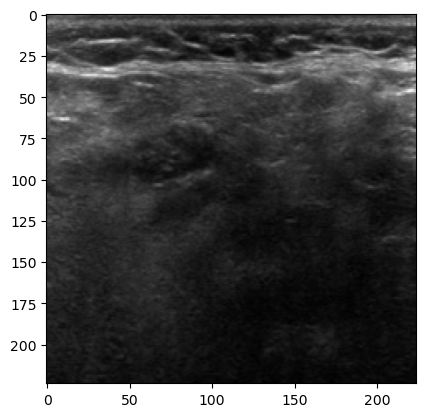

In [13]:
sample_img = transforms.functional.to_pil_image(img[0])
plt.imshow(sample_img)

In [14]:
import timm

class CustomModel(nn.Module):
    if CFG['MODEL'] == 1:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("resnet50", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x

    elif CFG['MODEL'] == 2:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("vgg16_bn", pretrained=True)
            self.model.head.fc = nn.Linear(in_features=4096, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)
            
            return x
    
    elif CFG['MODEL'] == 3:
        def __init__(self, classes=2):
            super().__init__()
            self.model = timm.create_model("inception_v3", pretrained=True)
            self.model.fc = nn.Linear(in_features=2048, out_features=classes, bias=True)
            self.softmax = nn.Softmax(dim=-1)

        def forward(self, x):
            x = self.model(x)
            x = self.softmax(x)

            return x

/home/user1/바탕화면/yes/envs/test/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [15]:
model = CustomModel().to(device)
model

CustomModel(
  (model): InceptionV3(
    (Conv2d_1a_3x3): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2a_3x3): ConvNormAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Conv2d_2b_3x3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [16]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

# TRAIN DATASET

In [17]:
def train_loop(dataloader, model, optimizer, loss_fn, scheduler, model_save_path):
    # model.load_state_dict(torch.load(model_save_path))
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    best_loss = 100
    loss_hist=[]
    acc_hist=[]

    for epoch in range(CFG['EPOCHS']):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output.argmax(1)==y.argmax(1)).detach().cpu().sum().item()

            if batch % 50 == 0:
                print(f"Batch loss : {(loss):>.5f} {batch}/{size}")

        curr_loss = loss_item/size
        curr_acc = correct/datasize
        loss_hist.append(curr_loss)
        acc_hist.append(curr_acc*100)

        if curr_loss < best_loss:
            best_loss = curr_loss
            best_loss_model = deepcopy(model.state_dict())

        print(f"Loss : {(curr_loss):>.5f} ACC : {(curr_acc*100):>.2f}%")

        epoch_end = time.time()
        scheduler.step()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(best_loss_model, model_save_path)

    return loss_hist, acc_hist

In [18]:
loss_hist, acc_hist = train_loop(train_dataloader, model, optimizer, loss_fn, scheduler, model_save_path)

Start epoch : 1
Batch loss : 0.68112 0/69
Batch loss : 0.49636 50/69
Loss : 0.52232 ACC : 78.36%
End epoch : 1
Epoch time : 0.0 min 33.75295424461365 sec

Start epoch : 2
Batch loss : 0.41444 0/69
Batch loss : 0.36951 50/69
Loss : 0.37359 ACC : 94.02%
End epoch : 2
Epoch time : 0.0 min 30.23948574066162 sec

Start epoch : 3
Batch loss : 0.35531 0/69
Batch loss : 0.33354 50/69
Loss : 0.34380 ACC : 97.05%
End epoch : 3
Epoch time : 0.0 min 30.58004093170166 sec

Start epoch : 4
Batch loss : 0.32155 0/69
Batch loss : 0.33572 50/69
Loss : 0.33474 ACC : 97.98%
End epoch : 4
Epoch time : 0.0 min 30.502715826034546 sec

Start epoch : 5
Batch loss : 0.33492 0/69
Batch loss : 0.32957 50/69
Loss : 0.32856 ACC : 98.55%
End epoch : 5
Epoch time : 0.0 min 30.202295541763306 sec

Start epoch : 6
Batch loss : 0.31858 0/69
Batch loss : 0.32106 50/69
Loss : 0.32706 ACC : 98.61%
End epoch : 6
Epoch time : 0.0 min 30.120923042297363 sec

Start epoch : 7
Batch loss : 0.31695 0/69
Batch loss : 0.31396 50/6

Text(0.5, 1.0, 'Train Loss')

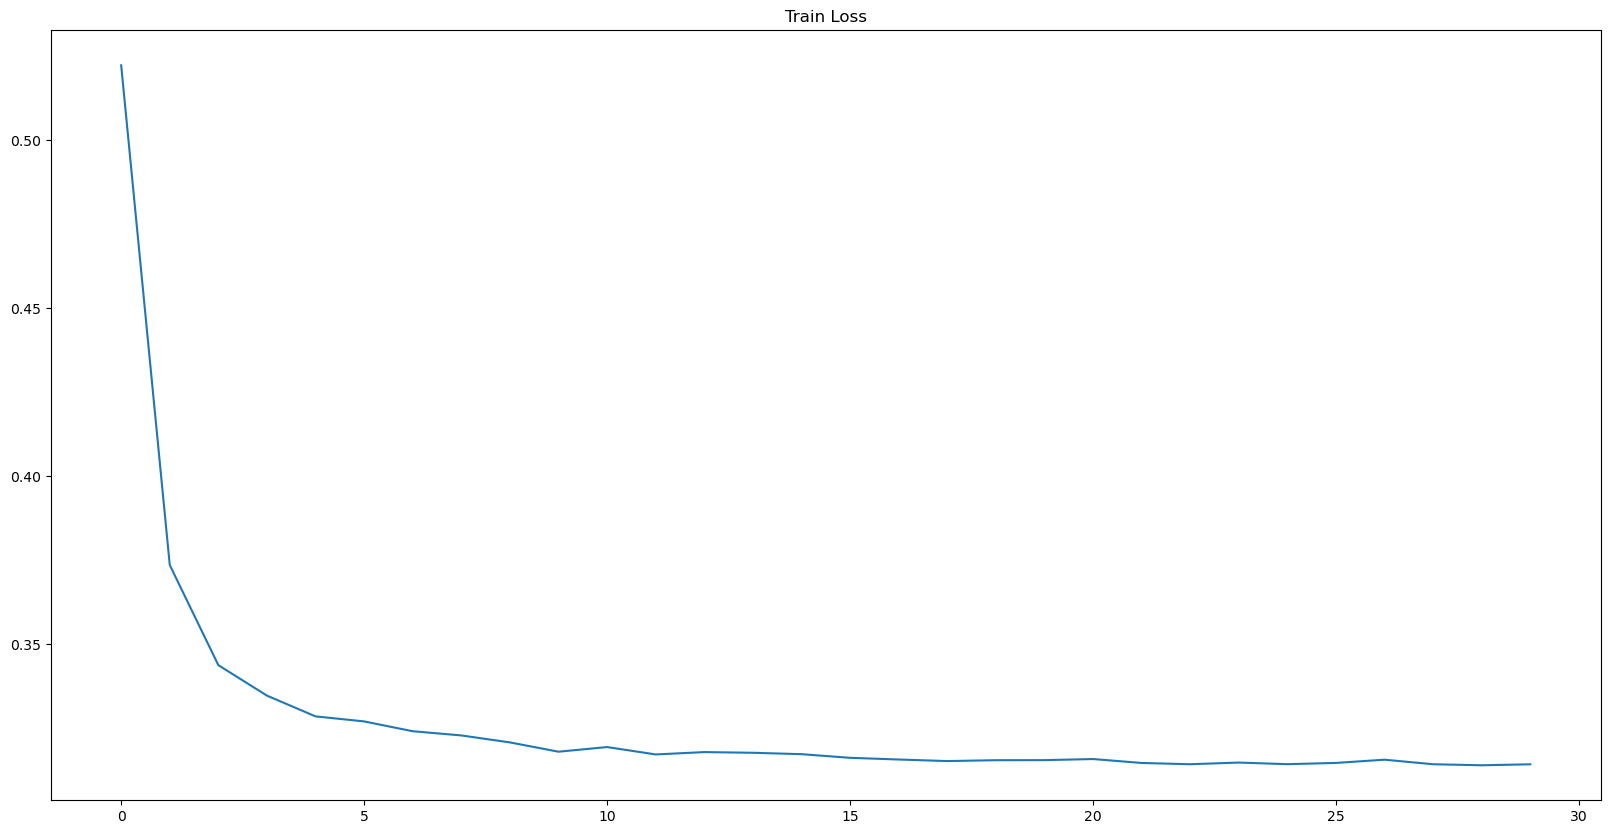

In [19]:
plt.figure(figsize=(20,10))
plt.plot(loss_hist)
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

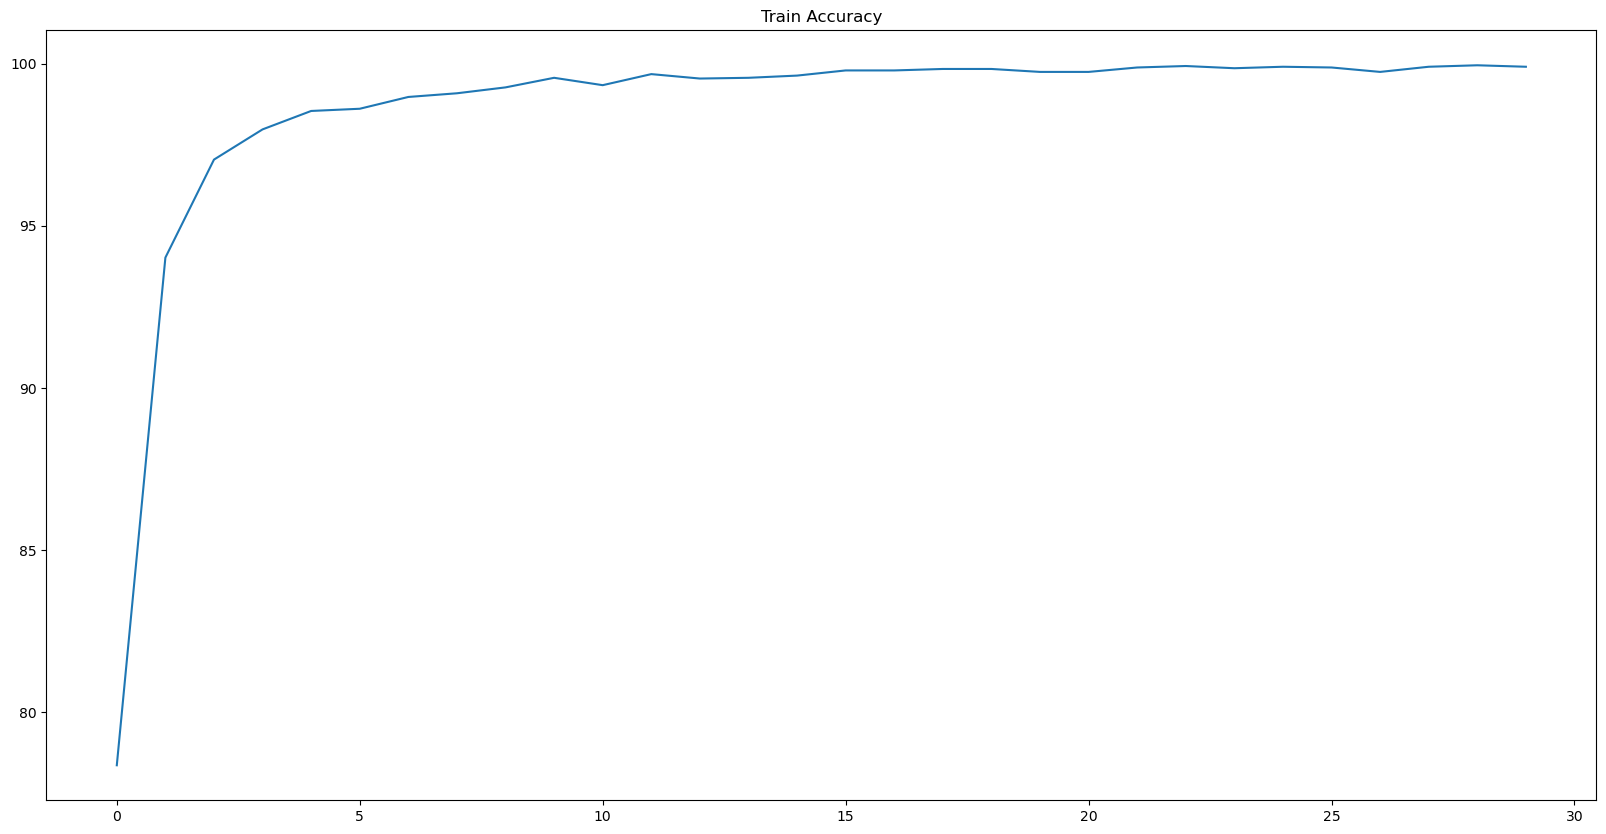

In [20]:
plt.figure(figsize=(20,10))
plt.plot(acc_hist)
plt.title('Train Accuracy')